In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from rep.estimators import TMVAClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
#from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [4]:
def compare_rocs(clf_dict, data_dict, 
                 loc_title = 'ROC comparison for electron data', 
                 color_dict=None,
                 size = (8,8)):
    keys = list(clf_dict.keys())
    results_dict = {}
    
    if not color_dict:
        colors = plt.cm.rainbow(np.linspace(0,1,len(keys)))
        color_dict = {}
        for key, color in zip(keys, colors):
            color_dict[key] = color 
            
    plt.figure(figsize=size)
    for key in keys:
        cur_results = dict.fromkeys(['ROC_curve', 'ROC_AUC'])
        cur_clf = clf_dict[key]
        print('Fitting {0:}.'.format(key))
        cur_clf.fit(data_dict['train'][features], data_dict['train_labels'])
        cur_probs = cur_clf.predict_proba(data_dict['test'][features])
        cur_auc = roc_auc_score(data_dict['test_labels'], cur_probs[:, 1])
        cur_results['ROC_AUC'] = cur_auc
        fpr, tpr, _ = roc_curve(data_dict['test_labels'], cur_probs[:, 1])
        cur_results['ROC_curve'] = fpr, tpr
        results_dict[key] = cur_results

        plt.plot(fpr, tpr, color=color_dict[key], label = key + " AUC = %.3f" % cur_results['ROC_AUC'])
    
    
    plt.title(loc_title)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc=4)
    plt.show()
    
    return results_dict

In [5]:
data_folder = 'data/MC12/TrainMixture/' + \
'TrainAllTks-EvalAllTks-NoReweight/GhostAccFrac1.0/TMVA-NoPreSels-NoGECs/Electron/Upstream/'

data_folder = 'data/MC12/TrainMixture/' + \
'test/GhostAccFrac1.0/TMVA-NoPreSels-NoGECs/Electron/Upstream/'

signal_file = 'data_train_signal.csv'
background_file = 'data_train_bkg.csv'
data_signal = pd.read_csv(data_folder + signal_file, index_col=0)
data_bkg = pd.read_csv(data_folder + background_file, index_col=0)
features = np.loadtxt(data_folder + 'train_features.txt', dtype='str')

In [6]:
data_train_signal, data_test_signal = train_test_split(data_signal, test_size=0.3, random_state=42)
data_train_bkg, data_test_bkg = train_test_split(data_bkg, test_size=0.3, random_state=42)


train_data = pd.concat([data_train_signal, data_train_bkg], axis=0)
train_labels = np.concatenate((np.ones(len(data_train_signal)), np.zeros(len(data_train_bkg))), axis=0)

test_data = pd.concat([data_test_signal, data_test_bkg], axis=0)
test_labels = np.concatenate((np.ones(len(data_test_signal)), np.zeros(len(data_test_bkg))), axis=0)

sample_weight = np.concatenate((np.ones(len(data_train_signal)),
                                   1 * np.ones(len(data_train_bkg))), axis=0)

In [7]:
features = train_data[features].columns[(train_data[features].var(skipna=False) != 0)]

In [8]:
my_clfs = {}
my_clfs['TMVA kMLP'] = TMVAClassifier(method='kMLP',
                      features=features,
                      factory_options="V:!Silent:!Color:!DrawProgressBar",
                      H='true',
                      V='true',
                      EpochMonitoring='true',
                      HiddenLayers=1.4*len(features),
                      UseRegulator='true',
                      ConvergenceImprove = "1e-16",
                      ConvergenceTests = "15",
                      VarTransform = "Norm",
                      NCycles = 50,
                      NeuronType = "sigmoid",
                      TrainingMethod = "BP",
                      EstimatorType = "CE")
my_clfs['TMVA kBDT'] = TMVAClassifier(method='kBDT',
                      features=features,
                      factory_options="V:!Silent:!Color:!DrawProgressBar",
                      H='false',
                      V='true',
                      NTrees=800,
                      VarTransform = "Norm",
                      BoostType = "AdaBoost",
                      PruneMethod = "CostComplexity",
                      PruneStrength = -1,
                      MaxDepth = 3,
                      PruningValFraction = 0.3)

xgb_params = {'base_score': 0.5,
 'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.03,
 'max_depth': 3,
 'n_estimators': 800,
 'nthread': 8,
 'objective': 'binary:logistic',
 'seed': 0,
 'silent': True,
 'subsample': 0.5}

my_clfs['XGB'] = XGBClassifier(**xgb_params )

ada_params = {'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 0.3,
 'n_estimators': 800,
 'random_state': 0}

my_clfs['AdaBoost'] = AdaBoostClassifier(**ada_params)

rf_params = {'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': 8,
 'random_state': 0}

my_clfs['RF'] = RandomForestClassifier(**rf_params)
#my_clfs['Bagged XGB'] = BaggingClassifier(base_estimator=my_clfs['XGB'])

data_el = {}
data_el['train'] = train_data
data_el['train_labels'] = train_labels
data_el['test'] = test_data
data_el['test_labels'] = test_labels
data_el['features'] = features

Fitting XGB.
Fitting RF.
Fitting TMVA kBDT.
Fitting AdaBoost.
Fitting TMVA kMLP.


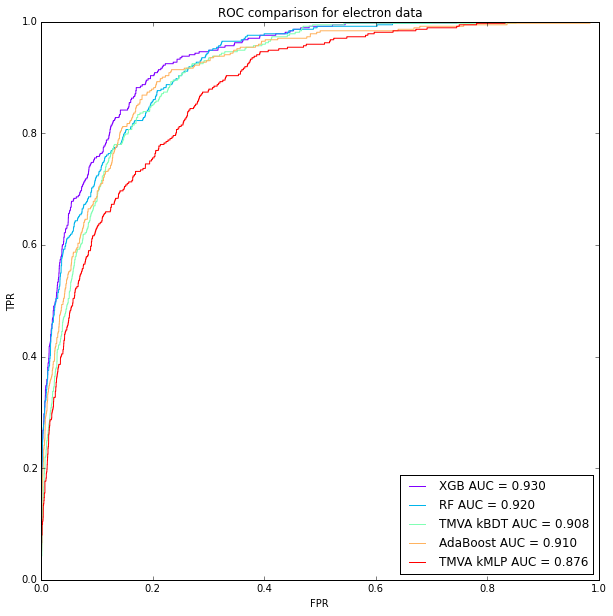

In [9]:
a = compare_rocs(my_clfs, data_el, size=(10,10))

In [35]:
-

Train on 10000 samples, validate on 3999 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


6001/6001 [==============================] - 0s     


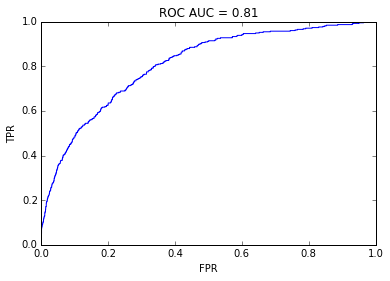

In [36]:
prob_keras = model.predict_proba(X_test)

roc_auc = roc_auc_score(test_labels, prob_keras[:, 1])
fpr, tpr, _ = roc_curve(test_labels, prob_keras[:, 1])

plt.plot(fpr, tpr)
plt.title("ROC AUC = %.2f" % roc_auc)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()